# Problem 1


In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## Load training data

In [2]:
# Load tensors from the file
loaded_tensors = torch.load('exercise_2_problem_1_data.pth')

# Retrieve tensors
X_tensor = loaded_tensors['X_tensor']
Y_tensor = loaded_tensors['Y_tensor']

# Create a dataset & DataLoader for mini-batch training
dataset = TensorDataset(X_tensor, Y_tensor)

batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## a) Finalize model definition

In [3]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, output_dim)
        )

    def forward(self, x):
        return self.layers(x)


## b) Write optimization loop

In [4]:
model = RegressionModel(100, 2)

criterion = nn.MSELoss()
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_epochs = 250
printing_interval = num_epochs // 10 # Avoid printing hundreds or thousands of losses, to keep the notebook cleaner
losses_ = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_x, batch_y in dataloader:
        # 1) Zero the gradients
        optimizer.zero_grad()
        # 2) Forward pass
        preds = model(batch_x)
        # 3) Compute loss (MSE)
        loss = criterion(preds, batch_y)
        # 4) Backprop
        loss.backward()
        # 5) Update parameters
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    losses_.append(avg_loss)
    
    
    if(epoch % printing_interval == 1):
        print(f"Epoch [{epoch+1}/{num_epochs}] - MSE Loss: {avg_loss:.6f}")


Epoch [2/250] - MSE Loss: 0.913816
Epoch [27/250] - MSE Loss: 0.189765
Epoch [52/250] - MSE Loss: 0.062930
Epoch [77/250] - MSE Loss: 0.020868
Epoch [102/250] - MSE Loss: 0.006340
Epoch [127/250] - MSE Loss: 0.001762
Epoch [152/250] - MSE Loss: 0.000406
Epoch [177/250] - MSE Loss: 0.000090
Epoch [202/250] - MSE Loss: 0.000017
Epoch [227/250] - MSE Loss: 0.000003


## c) Plot errors on log-scale

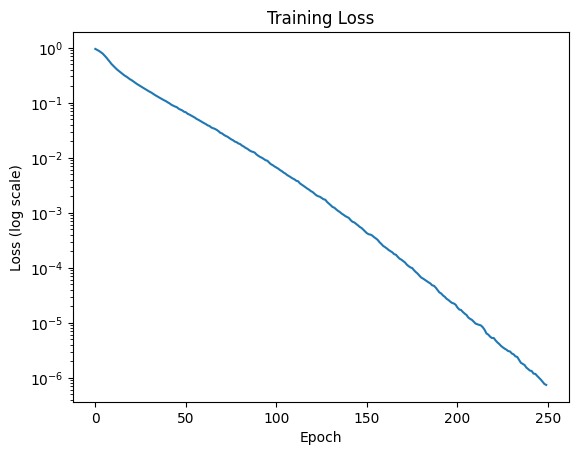

In [5]:
plt.plot(losses_)
plt.yscale('log')  # set y-axis to log-scale
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss')
plt.show()

## e) Report your choices

* The Adam optimizer with a 1e-4 learning rate and batch size of 128 is selected.

* The threshold 1e-6 was reached in 250 epochs.

## d) Computing the gradient norms

In [6]:
model.eval()

grad_norms = []  # to store gradient norms for each batch

# Loop over batches
for batch_x, batch_y in dataloader:
    optimizer.zero_grad()           # Zero the gradients
    preds = model(batch_x)          # Forward pass
    loss = criterion(preds, batch_y)  # Compute loss
    loss.backward()                 # Compute gradients via backpropagation
    
    # Compute total L2 norm across all model parameter gradients
    total_norm = 0.0
    for p in model.parameters(): # Loop over model parameters
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)  # L2 norm of the gradient for this parameter
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5 # sqrt of sum of squares
    grad_norms.append(total_norm)

# Convert to numpy array for statistics
grad_norms = np.array(grad_norms)
mean_gn = grad_norms.mean()
std_gn  = grad_norms.std()
min_gn  = grad_norms.min()
max_gn  = grad_norms.max()

print("Gradient Norm stats for evaluation pass:")
print(f"  Mean  : {mean_gn:.6f}")
print(f"  Std   : {std_gn:.6f}")

Gradient Norm stats for evaluation pass:
  Mean  : 0.003642
  Std   : 0.000498


# Problem 2

## a) Generate training/testing data

In [7]:
# N samples with D inputs and O outputs
N = 100
D = 10
O = 5

# Random mapping from x to y, as small neural network
class CreationModel(nn.Module):
  def __init__(self, D, O, M):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(D, M),
      nn.Tanh(),
      nn.Linear(M, O)
    )

  def forward(self, x):
    return self.layers(x)

# For getting the same data
torch.manual_seed(78798)

# Training data
x = torch.randn(N, D)
noiselevel = 0.1
modelGenerate = CreationModel(D,O,5)
modelGenerate.eval()
y = modelGenerate(x).clone().detach() + noiselevel*torch.randn(N, O)

# Test data
N_test = 10000
x_test = torch.randn(N_test, D)
y_test = modelGenerate(x_test).clone().detach()  + noiselevel*torch.randn(N_test, O)

#### Create model

In [8]:
class RegressionModel(nn.Module):
  def __init__(self, D, O, M):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(D, M),
      nn.Tanh(),
      nn.Linear(M, M),
      nn.Tanh(),
      nn.Linear(M, O)
    )

  def forward(self, x):
    return self.layers(x)

### b) Train model and validate double descent

In [9]:
# Use full data for gradients
B = N
data_loader = DataLoader(TensorDataset(x,y), batch_size=B, shuffle=True)

# logspace generates M=2 twice, so dropping the first entry
Mvalues = np.logspace(np.log10(2),np.log10(60),num=15,dtype='int')[1:]
losses = np.zeros((len(Mvalues),2))
for mi, M in enumerate(Mvalues):
    model = RegressionModel(D,O,M)
    objective = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    num_epochs = 5000
    losses_ = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        # loop over batches
        for i, data in enumerate(data_loader):
            # retrieve inputs and labels for this batch
            x_batch, y_batch = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward pass
            pred = model(x_batch)
            loss = objective(pred, y_batch)
            # bacMward pass
            loss.backward()
            # update
            optimizer.step()
            # update statistics
            epoch_loss += loss.item()
        losses_.append(epoch_loss)


    model.eval()
    pred = model(x_test)
    testloss = objective(pred, y_test)

    losses[mi,0] = losses_[-1]
    losses[mi,1] = testloss.item()

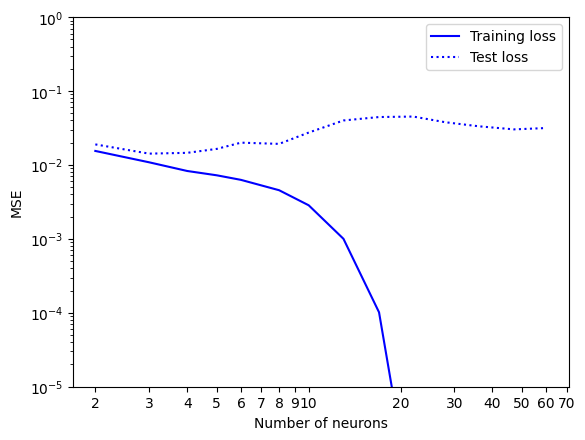

In [10]:
plt.loglog(Mvalues, losses[:,0], 'b-')
plt.loglog(Mvalues, losses[:,1], 'b:')
plt.legend(['Training loss', 'Test loss'])
ax = plt.gca(); ax.set_ylim([10**(-5),10**(0)])
ax.set_ylabel("MSE")
ax.set_xlabel("Number of neurons")
# Customize x-axis to show more detailed labels
from matplotlib.ticker import LogLocator, ScalarFormatter
ax.xaxis.set_major_locator(LogLocator(base=10.0, subs=np.arange(1, 10)))
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.show()

* The interpolation threshold is about at M=20. For that M, model has about DM+MM+MO=200+400+100=700 parameters.


### c) Having more data can hurt

Just repeat the same experiment with more data for two manually chosen M.

In [11]:
# Generate the larger training set, using the same process as before
N_large = 500
x_large = torch.randn(N_large, D)
y_large = modelGenerate(x_large).clone().detach() + noiselevel*torch.randn(N_large, O)


B = N
data_loader = DataLoader(TensorDataset(x_large,y_large), batch_size=B, shuffle=True)

Mvalues = [22,47]
losses2 = np.zeros((len(Mvalues),2))
for mi, M in enumerate(Mvalues):
    model = RegressionModel(D,O,M)
    objective = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    num_epochs = 5000
    losses_ = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        # loop over batches
        for i, data in enumerate(data_loader):
            # retrieve inputs and labels for this batch
            x_batch, y_batch = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward pass
            pred = model(x_batch)
            loss = objective(pred, y_batch)
            # backward pass
            loss.backward()
            # update
            optimizer.step()
            # update statistics
            epoch_loss += loss.item()
        losses_.append(epoch_loss)

    model.eval()
    pred = model(x_test)
    testloss = objective(pred, y_test)

    losses2[mi,0] = losses_[-1]
    losses2[mi,1] = testloss.item()

print("Test losses")
print("M = 22, N=100:", losses[9,1])
print("M = 22, N=500:", losses2[0,1])
print("M = 47, N=100:", losses[12,1])
print("M = 47, N=500:", losses2[1,1])

Test losses
M = 22, N=100: 0.045165468007326126
M = 22, N=500: 0.020338062196969986
M = 47, N=100: 0.030292870476841927
M = 47, N=500: 0.047420721501111984
